# Attention Please!

## Hello Cohere Team, thank you for reading this.

When I was training the models I noticed that the dropout rate for the default hugging face Bert model was different, one was passing 0.1 and in this implementation we were using 0.9, one interesting thing that I noticed was that when ever I was using the dropout in the network I was getting bad results, the numbers were below the expected value. However, when I turned the dropout off, I was able to train my model with a very higer accuracy. In some cases I was able to achieve accuracy more than what the assignment was expecting with that being said, my goal was to achieve the highest accuracy as possible there I used this technique and trained my model. The reason I mentioned this was because in the email you mentioned to report any unexpected behaviour which this was one of the phenomenon.

Thanks in advance and have a great day,

Amin Fadaeinejad



# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Monday October 2nd at 1pm PST.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

## Q1: What are some real world applications of dense sentence embeddings?

## Answer:

Dense sentence embedding has found many diverse real-world applications across many different domains, such as:

- **Search and Information Retrieval:** \\
Enhanced search algorithms: Embeddings can be used to represent queries and documents, enabling more accurate and semantically meaningful search results.

- **Question Answering:** \\
 Sentence embeddings can be used to identify similar questions, helping in question clustering and improving the performance of question-answering systems.
- **Sentiment Analysis:** \\
Embeddings capture the sentiment and context of sentences, aiding sentiment analysis tasks such as determining the sentiment of reviews, social media posts, or customer feedback.

- **Text Clustering and Categorization:** \\
Sentence embeddings facilitate the grouping of similar documents or sentences together in an unsupervised manner, aiding in content organization and categorization.

- **Semantic Textual Similarity:** \\
Sentence embeddings enable the comparison of semantic similarity between sentences, which is useful in tasks like duplicate detection, paraphrase identification, and coreference resolution.
- **Recommendation Systems:** \\
Sentence embeddings can be employed to represent user preferences and content items, improving the performance of recommendation systems by suggesting items with similar semantic content.
- **Information Extraction:** \\
Embeddings can assist in identifying and extracting named entities from text by capturing the contextual information associated with entities.

These applications highlight the versatility of dense sentence embeddings in various natural language processing (NLP) tasks, making them a valuable tool for improving the understanding and processing of human language in diverse contexts.

## Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

## Answer:
There are multiple different ways to calculate the embedding of a sentence without using the large language model:
- **Word Averaging:** \\
One of the older approaches to calculating a sentence embedding was taking the average of the word's embeddings in the sentence. While it might sound quite simple and straightforward, it might not be capable of capturing complex relationships and contextual meaning.
- **TF-IDF Weighted Averaging:** \\
Similar to word averaging, but in this scenario, words are weighted based on their Term Frequency-Inverse Document Frequency (TF-IDF) scores, giving more value and weight to the words that rarely appeared and providing more meaning.
- **Network Based:** \\
There are other Deep Neural networks before the existence of the transformer models that we trained for this specific task, e.g., vector of locally aggregated word embeddings (VLAWE) or Doc2Vec. Doc2Vec is an extension of Word2Vec, which represents the sentence of a document as fixed-size vectors. It learns to predict words in a context like Word2Vec but includes an additional paragraph ID or label for context.

**Imports**

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
%pip install transformers
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
#from transformers import AutoModel

In [ ]:
# Need these extra lib for clean and professional code documentation
from typing import Dict, List, Union

## **Coding Challenge Part 1: Debugging custom BERT code [7 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 7 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 7 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
def gelu(x: torch.Tensor) -> torch.Tensor:
    """
    The Gelu activation function.
    :param x: torch.Tensor
        The input of the activation function
    :return: torch.Tensor
        The output of the Gelu activation function
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    """
    A Configuration model containing all the configuration hyper-parameters
    """
    def __init__(self,
                 vocab_size,  # The size of the dictonary of words
                 hidden_size=768,  # The hidden layer size
                 num_hidden_layers=12,  # The number of hidden layers
                 num_attention_heads=12,  # The hidden layer size
                 intermediate_size=3072,  # The intermediate layer size
                 dropout_prob=0.9,  # The drop out probability
                 max_position_embeddings=512,  # The max size that position embedding could have
                 type_vocab_size=2,  # The type vocab size
                 initializer_range=0.02):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
    """
    Similar to `torch.nn.LayerNorm` this module applies Layer Normalization to the input
    tensor along a specified dimension. Layer Normalization is a technique used
    to normalize the activations of a layer, mitigating issues related to
    internal covariate shift.
    """
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Bug #1:
        The implementation of Layer Norm had some bugs.
        Visit: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
        For more references.

        Bug #1.1: Need to calculate the mean of the input tensor based on the last dimension, not on the first dimension
        in which represents the batch. Initially is calculated the average over the batch which was incorrect.

        Bug #1.2: For calculating the variance, the mean should be subtracted from the data not added with the data,
        additionally, we want to calculate the average over the last dimension, not the first dimension in which
        represents the batch.

        Bug #1.3: For calculating the final normalized output we will still need to subtract the mean from the data not
        the other way around (adding mean and data).

        Code Edit:
        >>
        u = x.mean(0, keepdim=True) -> mean = x.mean(dim=-1, keepdim=True)
        s = (x + u).pow(2).mean(0, keepdim=True) -> var = ((x - mean).pow(2)).mean(dim=-1, keepdim=True)
        x = (x + u) / torch.sqrt(s + self.variance_epsilon) ->
        return self.gamma * x + self.beta
        """
        mean = x.mean(dim=-1, keepdim=True)  # Edited line #1.1
        var = ((x - mean).pow(2)).mean(dim=-1, keepdim=True)  # Edited line #1.2
        std = (var + self.variance_epsilon).sqrt()  # Edited line #1.3
        y = (x - mean) / std
        return self.gamma * y + self.beta


class MLP(nn.Module):
    """
    The multi layer perceptron of the Bert model, consists of two linear
    following with a GeLU activation function in between.
    """
    def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

    def forward(self, x):
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    """
    The Bert Layer in the transformer model, which consists of different
    sections such as the linear layers for converting the key, query and value
    to their embedding representation. Additionally having the self attention
    part with some multi layer perceptron with normalization terms.
    """
    def __init__(self, config):
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        """
        Bug #2
        This bug couldn't be spot easily since the self.all_head_size and config.hidden_size were holding the same
        value, but it you play with the hyper parameters of this model e.g., hidden_size and assign a odd number, you
        would be receiving errors.

        Code Edit:
        >>
        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size) ->
        self.attn_out = nn.Linear(self.all_head_size, config.hidden_size)
        """
        self.attn_out = nn.Linear(self.all_head_size, config.hidden_size)  # Edited line #2
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        """
        Split the vector in to multi-heads.
        :param tensor: torch.Tensor
            The input tensor that needs to be splitted
        :param num_heads: int
            The number of heads in the multi-head attention model
        :param attention_head_size: List
            The size of each attention head
        :return: torch.Tensor
            The splitted tensor
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor, num_heads, attention_head_size):
        """
        Merge the mutiple heads into one single head.
        :param tensor: torch.Tensor
            The input tensor that needs to be resized
        :param num_heads: int
            The number of heads in the multi-head attention model
        :param attention_head_size: List
            The size of each attention head
        :return:
            The destination size of the merged multi-head.
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        """
        The attention part of the Bert model.
        :param q: torch.Tensor
            The Query of the Transformer
        :param k: torch.Tensor
            The Key of the Transformer
        :param v: torch.Tensor
            The Value of the Transformer
        :param attention_mask: torch.Tensor
            A mask that tells which part of the input is empty token.
        :return a: torch.Tensor
            The output of the attention model in Bert
        """
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        """
        Bug #3: The dimensions of the query and key must be re-arranged in a way that we are capable of multiplying them
        in each other. That is way we needed to transpose the key in a proper format.

        Code Edit:
        >>
        s = torch.matmul(q, k) -> s = torch.matmul(q, k.transpose(-1, -2))
        """
        s = torch.matmul(q, k.transpose(-1, -2))  # Edited line #3

        s = s / math.sqrt(self.attention_head_size)

        """
        Bug #4: Need to mask out the segments of the input in which don't have valid tokens (words), and since the
        model is going through a softmax function, it would be valid to replace the scores which didn't have a valid
        word into 0. Since the score goes though a softmax function we should replace the value with -inf. Initially
        the replacement was with +int, which was wrong.

        Code Edit:
        >>
        s = torch.where(mask, s, torch.tensor(float('inf'))) ->
        s = torch.where(mask, s, torch.tensor(float('-inf')))
        """
        s = torch.where(mask, s, torch.tensor(float('-inf')))  # Edited line #4

        """
        Bug #5
        In the original implementation of the model, if was required to apply softmax for the score vector, you can
        refer to the transformer paper "Attention is all you need". But initially it was just a 'p=s', which is
        incorrect, and must be replaced with a softmax function.

        Code edit:
        >>
        p = s ->
        p = nn.functional.softmax(s, dim=-1)
        """
        p = nn.functional.softmax(s, dim=-1)  # Edited line #5
        p = self.dropout(p)

        a = torch.matmul(p, v)
        return a

    def forward(self, x, attention_mask):
        q, k, v = self.query(x), self.key(x), self.value(x)

        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask)
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        """
        Bug #6.1: In the official Bert implementation the input of the LayerNorm should be the hidden state summed with
        the input of the attention model.
        Code Edit:
        >>
        a = self.ln1(a) -> a = self.ln1(a + x)
        >>
        """

        """
        Bug #6.2: Similar to 6.1 the input of the second LayerNorm should also be the sum of the hidden state and the
        output of the previous LayerNorm.
        Code Edit:
        >>
        m = self.ln2(m)  -> m = self.ln2(m + a)
        >>
        """
        a = self.ln1(a + x)  # Edited line #6.1

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(m + a)  # Edited line #6.2

        return m


class Bert(nn.Module):
    """
    The BERT model was proposed in BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
    by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. It’s a bidirectional transformer pretrained
    using a combination of masked language modeling objective and next sentence prediction on a large corpus
    comprising the Toronto Book Corpus and Wikipedia.
    :param config_dict: Config
        The Configuration model containing all of the hyper-parameters.
    :return x: torch.Tensor [B, NumberWord, Embedding_size]
        The embedding representation of the input text.
    :return o: torch.Tensor [B, Embedding_size]
        The pooled embedding of the Bert model
    """
    def __init__(self, config_dict):
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
            'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
            'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
            'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        """
        Bug #7
        In the original bert model the work embedding, position embeding and the token type embedding must be summed up
        all together. Initially it these embedding were concatinated which resulted an error due to incopatibility of
        the dimensions in the next layers.

        Code edit:
        >>>
        x = torch.cat((self.embeddings.token(input_ids),
                       self.embeddings.position(position_ids),
                       self.embeddings.token_type(token_type_ids)),
                      dim=-1) ->
        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(
            token_type_ids)
        """
        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(
            token_type_ids)  # Edited line #7

        x = self.dropout(self.ln(x))

        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return x, o

    def load_model(self, path: str):
        """
        Load the weights of the model
        :param path: str
            The location which the model weights exist
        """
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-02 17:18:18--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-02 17:18:18--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin.2’

bert_tiny.bin.2     100%[===================>]  16.74M  --.-KB/s    in 0.07s   

2023-10-02 17:18:18 (241 MB/s) - ‘bert_tiny.bin.2’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


# Functions

In [ ]:
def convert_list(source_list: List, device: str) -> List:
    """
    Convert the list to device (cpu or cuda), since the
    :param source_list: List
        The initial list
    :param device: str
        The destination device
    :return:
        list of the destination
    """
    return [source_list[i].to(device) for i in range(len(source_list))]

# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

# Answer:
Pearson and Spearman correlation are both correlation coefficients, but they measure different types of relationships between variables. Pearson measures the linear relationship between two variables, while Spearman measures the monotonic relationship between two variables1. It is recommended to calculate both Pearson and Spearman correlation when doing data exploration, as any difference between the two could shed additional light on the relationship between variables, as well as any anomalies in the data itself.


Reference: https://anyi-guo.medium.com/correlation-pearson-vs-spearman-c15e581c12ce

- **Pearson’s correlation (P):** \\
Pearson's correlation, named after Karl Pearson, serves to illustrate the linear relationship between two variables. The calculation involves determining the correlation coefficient using the mean and standard deviation, making it a parametric method. The resulting correlation value ranges between -1 and 1, where 1 indicates a complete positive correlation and -1 represents a full negative correlation.
<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*NQSf_XQ8prB5mRBhrjl4Kg.png" />
</p>
Utilizing mean and standard deviation implies a Gaussian-like distribution assumption for the data. Despite being a widely adopted method and the default choice in many programming languages (e.g., Pandas dataframe's corr() method), Pearson's correlation has its drawbacks. It is particularly sensitive to outliers, and its interpretation can be misleading based on the dataset. An example illustrating this sensitivity is provided below. Before delving into that, let's briefly introduce the concept of Spearman Correlation.

- **Spearman Correlation (S):**
Spearman correlation, named after Charles Spearman, serves as the non-parametric alternative to Pearson's correlations. It is employed under the following conditions:
<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*NQSf_XQ8prB5mRBhrjl4Kg.png" />
</p>
When the association between the two variables is non-linear, exhibiting varying strength based on the data.
When the variables demonstrate a distribution that is not Gaussian.
Much like Pearson’s Correlation, Spearman also yields a value within the [-1, 1] range, representing full negative correlation and full positive correlation, respectively.

- **Additional Point:** \
If S and P are very different, you should check if there’re any outliers in the data, and consider removing or replacing them from the calculation. Spearman’s correlation is more robust to outliers than Pearson’s correlation.


In [ ]:
class STSDataSet(DataLoader):

    def __init__(self, score, sentence1, sentence2):
        assert len(score) == len(sentence1.data['input_ids']) and len(score) == len(sentence2.data['input_ids']), \
            "Sentences don't have the same size."
        self.score = score
        self.sentence1_id = sentence1.data['input_ids']
        self.sentence2_id = sentence2.data['input_ids']
        self.sentence1_mask = sentence1.data['attention_mask']
        self.sentence2_mask = sentence2.data['attention_mask']

    def __len__(self):
        return len(self.score)

    def __getitem__(self, item):
        return self.score[item], (self.sentence1_id[item], self.sentence1_mask[item]), (self.sentence2_id[item],
                                                                                        self.sentence2_mask[item])

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-02 17:18:39--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-02 17:18:40--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   487KB/s    in 0.8s    



In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t', quoting=csv.QUOTE_NONE)
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name: str) -> Dict:
    """
    Load the STS data loader
    :param file_name: str
        The location of the dataset.
    :return: Dict
        A dictionary that contains the dataset.
    """
    data = pd.read_csv(file_name, on_bad_lines='skip', quoting=csv.QUOTE_NONE, compression='gzip',
                       delimiter='\t')
    data = data.rename(columns={'score': 'label'})
    train = data[data['split'] == 'train'][['label', 'sentence1', 'sentence2']]
    test = data[data['split'] == 'test'][['label', 'sentence1', 'sentence2']]
    dev = data[data['split'] == 'dev'][['label', 'sentence1', 'sentence2']]
    sts_samples = {'train': train, 'test': test, 'dev': dev}
    return sts_samples


def tokenize_sentence_pair_dataset(dataset: pd.DataFrame, tokenizer: AutoTokenizer, max_length=128) -> DataLoader:
    """
    Extracts the sentences from the data frame and return the data loader.
    :param dataset: pd.DataFrame
    :param tokenizer: AutoTokenizer
        The tokenizer model
    :param max_length: int
        The maximum length of the sentence that will be tokenized.
    :return:
    """
    score = dataset['label'].to_numpy().tolist()
    sentence1_embedding = tokenizer(dataset['sentence1'].to_numpy().tolist(), return_tensors='pt', padding='max_length',
                                    max_length=max_length, truncation=True)
    sentence2_embedding = tokenizer(dataset['sentence2'].to_numpy().tolist(), return_tensors='pt', padding='max_length',
                                    max_length=max_length, truncation=True)
    if type(score[0]) == str:
        tokenized_dataset = NLIDataSet(score=score, sentence1=sentence1_embedding, sentence2=sentence2_embedding)
    elif type(score[0]) == float:
        tokenized_dataset = STSDataSet(score=score, sentence1=sentence1_embedding, sentence2=sentence2_embedding)
    else:
        tokenized_dataset = STSDataSet(score=score, sentence1=sentence1_embedding, sentence2=sentence2_embedding)
        print("Warning! Are you sure about the correct dataset?")
    return tokenized_dataset


def get_dataloader(tokenized_dataset: DataLoader, batch_size: int, shuffle: bool = False) -> DataLoader:
    """
    Modify some features of the data loader for training
    :param tokenized_dataset:
        The dataset that needs to be modified.
    :param batch_size: int
        Batch size for training the model
    :param shuffle: bool
        If the data loader should shuffle the data samples
    :return: DataLoader
        The created DataLoader
    """
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Calculate the Cosine similarity between vectors.
    :param a: torch.Tensor, [B, v_dim]
        The first embedding vector
    :param b: torch.Tensor, [B, v_dim]
        The second embedding vector
    :return similarity: torch.Tensor [B, B]
        The similarity matrix showing the similarity between vectors
    """
    L2_norm = torch.linalg.vector_norm(a, dim=1).unsqueeze(1)@torch.linalg.vector_norm(b, dim=1).unsqueeze(0)
    similarity = (a@b.T) / L2_norm
    return similarity


def eval_loop(model: nn.Module, eval_dataloader: DataLoader, device: str) -> List[Union[float, float]]:
    """
    The function that will evaluate the performance of the model and will return two pearson and spearman cosine error.
    :param model: nn.Module
        The model that will be evaluated
    :param eval_dataloader: DataLoader
        The data loader that will be used for evaluation.
    :param device: str
        Which device is this process going to run on.
    :return eval_pearson_cosine: float
        The pearson error of evaluating our model
    :return eval_spearman_cosine: float
        The spearman error of evaluating our model
    """
    ground_score = []
    predict_score = []
    model = model.to(device)
    model = model.eval()
    model_name = model.__class__.__name__
    for score, sentence1, sentence2 in tqdm(eval_dataloader):
        assert model_name == 'BertClassifier' or model_name == 'BertModel' or model_name == 'Bert' or model_name == \
               'BertContrastive' or model_name == 'SupremeBert', 'Model type not valid!'
        sentence1 = convert_list(sentence1, device)  # [sentence1[0].to(device), sentence1[1].to(device)]
        sentence2 = convert_list(sentence2, device)  # [sentence2[0].to(device), sentence2[1].to(device)]

        if model_name == 'BertClassifier' or model_name == 'SupremeBert':
            predict_score.append(torch.argmax(model(sentence1, sentence2), dim=1).detach().cpu())
            ground_score.append(score.detach().cpu())
        elif model_name == 'BertContrastive':
            predict_score.append(model(sentence1, sentence2).detach().cpu())
            ground_score.append(score.detach().cpu())
        elif model_name == 'BertModel' or model_name == 'Bert':
            sentence1_embed = model(input_ids=sentence1[0].to(device), attention_mask=sentence1[1].to(device))[1].cpu()
            sentence2_embed = model(input_ids=sentence2[0].to(device), attention_mask=sentence2[1].to(device))[1].cpu()

            cosine_similarity = cosine_sim(sentence1_embed, sentence2_embed)
            predict_score.append(torch.diagonal(cosine_similarity).detach())
            ground_score.append(score.detach())

    predict_score = torch.cat(predict_score).detach().numpy()
    ground_score = torch.cat(ground_score).detach().numpy()
    eval_pearson_cosine = pearsonr(ground_score, predict_score).statistic
    eval_spearman_cosine = spearmanr(ground_score, predict_score).statistic
    return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

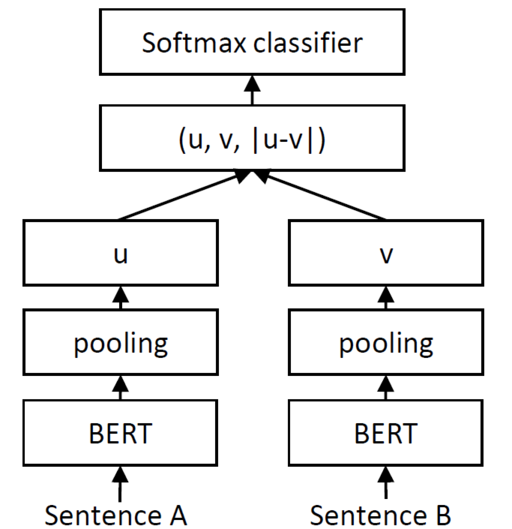

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method. Please follow the architecture illustrated in the given figure.

In [ ]:
class NLIDataSet(DataLoader):

    def __init__(self, score, sentence1, sentence2):
        assert len(score) == len(sentence1.data['input_ids']) and len(score) == len(sentence2.data['input_ids']), \
            "Sentences don't have the same size."
        classes = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
        score = [classes.get(key) for key in score]

        self.score = score
        self.sentence1_id = sentence1.data['input_ids']
        self.sentence2_id = sentence2.data['input_ids']
        self.sentence1_mask = sentence1.data['attention_mask']
        self.sentence2_mask = sentence2.data['attention_mask']

    def __len__(self):
        return len(self.score)

    def __getitem__(self, item):
        return self.score[item], (self.sentence1_id[item], self.sentence1_mask[item]), (self.sentence2_id[item],
                                                                                        self.sentence2_mask[item])

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 17:21:07--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 172.67.180.145, 104.21.67.200, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|172.67.180.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 17:21:07--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  13.2MB/s    in 2.9s    

2023-10-02 17:21:11 (1

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


In [ ]:
def load_nli_dataset(file_name: str) -> Dict:
    """
    Load the NLI dataset as a dictionary
    :param file_name: str
        The location of the NLI dataset
    :return: Dict
        Dictionary containing the train, test, dev segments of the dataset
    """
    data = pd.read_csv(file_name, on_bad_lines='skip', quoting=csv.QUOTE_NONE, compression='gzip',
                       delimiter='\t')
    train = data[data['split'] == 'train'][['label', 'sentence1', 'sentence2']]
    test = data[data['split'] == 'test'][['label', 'sentence1', 'sentence2']]
    dev = data[data['split'] == 'dev'][['label', 'sentence1', 'sentence2']]
    nli_samples = {'train': train, 'test': test, 'dev': dev}
    return nli_samples


def train_loop(model: nn.Module, optimizer, train_dataloader: DataLoader, num_epochs: int, device: str):
    """
    The loop for training our models
    :param model: nn.Module
        The network that we want to train
    :param optimizer: Optimizer
        The Optimization method we are using for training the model.
    :param train_dataloader: DataLoader
        The DataLoader module, for the dataset.
    :param num_epochs: int
        Number of epochs to be trained
    :param device: str
        The destination device
    :return:
    """
    assert model.model_type == 'classification' or model.model_type == 'regression', "Model type not valid!"
    if model.model_type == 'classification':
        loss_function = nn.CrossEntropyLoss()
    elif model.model_type == 'regression':
        loss_function = nn.MSELoss()
    else:
        loss_function = None
        print("Loss function not defined!")

    model.to(device)
    for _ in tqdm(range(num_epochs)):
        for label, sentence1, sentence2 in train_dataloader:
            label = label.to(device)
            if model.model_type == 'regression':
                label = label.float() - 1.0
            sentence1 = convert_list(sentence1, device)
            sentence2 = convert_list(sentence2, device)

            output = model(sentence1, sentence2)

            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()



In [ ]:
class Softmax(torch.nn.Module):
    def __init__(self, input_channel, output_channel):
        super(Softmax, self).__init__()
        self.layers = nn.Sequential(
            torch.nn.Linear(input_channel, int(input_channel / 2)),
            nn.ReLU(),
            torch.nn.Linear(int(input_channel / 2), output_channel),
        )

    def forward(self, x):
        output = self.layers(x)
        return output


class BertClassifier(nn.Module):
    def __init__(self, pretrained_model: nn.Module, max_length: int, num_labels: int, pool: str = None):
        super(BertClassifier, self).__init__()
        # Use the pretrained Bert model as base
        self.pretrained_model = pretrained_model.eval()
        self.pretrained_model.requires_grad = True
        # Add a Softmax classifier
        self.softmax_classifier = Softmax(max_length * 3, num_labels)
        self.sf = nn.Softmax(dim=1)
        assert pool == 'mean' or pool == 'max' or pool is None, "Pooling method not valid!"
        self.pool = pool
        self.model_type = 'classification'

    def forward(self, sentence1, sentence2):
        sentence1_embed = self.pretrained_model(input_ids=sentence1[0], attention_mask=sentence1[1])
        sentence2_embed = self.pretrained_model(input_ids=sentence2[0], attention_mask=sentence2[1])
        if self.pool == 'max':
            sentence1_embed = torch.max(sentence1_embed[0], dim=2)[0]
            sentence2_embed = torch.max(sentence2_embed[0], dim=2)[0]
        elif self.pool == 'mean':
            sentence1_embed = sentence1_embed[0].mean(2)
            sentence2_embed = sentence2_embed[0].mean(2)
        elif self.pool is None:
            sentence1_embed = sentence1_embed[1]
            sentence2_embed = sentence2_embed[1]

        embedding = torch.cat([sentence1_embed, sentence2_embed, torch.abs(sentence1_embed - sentence2_embed)], dim=1)
        output = self.softmax_classifier(embedding)
        # output = self.sf(output)  # Could also be used.
        return output


# **Training BertClassifier**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

# We will need the original Bert model for the Bert classifier
bert = Bert(bert_config).load_model('bert_tiny.bin')

bert_classifier = BertClassifier(bert, max_length=128, num_labels=num_labels)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/3 [00:00<?, ?it/s]

**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
result_from_classification = eval_loop(bert_classifier, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.42
Spearman correlation: 0.42


In [ ]:
result_from_classification = eval_loop(bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.60
Spearman correlation: 0.61


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
class BertContrastive(nn.Module):
    def __init__(self, pretrained_model: nn.Module, pool: str = None):
        super(BertContrastive, self).__init__()
        self.pretrained_model = pretrained_model.eval()
        self.pretrained_model.requires_grad = True
        assert pool == 'mean' or pool == 'max' or pool is None, "Pooling method not valid!"
        self.pool = pool
        self.model_type = 'regression'

    def forward(self, sentence1, sentence2):
        sentence1_embed = self.pretrained_model(input_ids=sentence1[0], attention_mask=sentence1[1])
        sentence2_embed = self.pretrained_model(input_ids=sentence2[0], attention_mask=sentence2[1])
        if self.pool == 'max':
            sentence1_embed = torch.max(sentence1_embed[0], dim=2)[0]
            sentence2_embed = torch.max(sentence2_embed[0], dim=2)[0]
        elif self.pool == 'mean':
            sentence1_embed = sentence1_embed[0].mean(2)
            sentence2_embed = sentence2_embed[0].mean(2)
        elif self.pool is None:
            sentence1_embed = sentence1_embed[1]
            sentence2_embed = sentence2_embed[1]
        cosine_similarity = cosine_sim(sentence1_embed, sentence2_embed)
        return torch.diagonal(cosine_similarity)

# **Training BertContrastive**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 6
batch_size = 8
num_labels =3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size)


bert = Bert(bert_config).load_model('bert_tiny.bin')
bert_contrastive = BertContrastive(bert)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/6 [00:00<?, ?it/s]

# **Evaluation BertContrastive**

In [ ]:
result_from_contrastive = eval_loop(bert_contrastive, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.33
Spearman correlation: 0.33


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

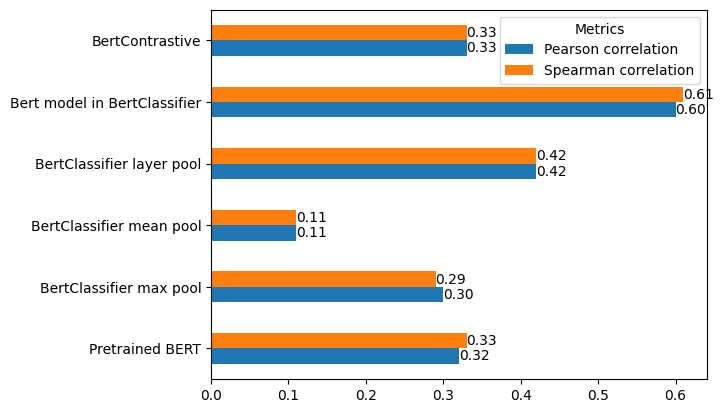

In [ ]:
import pandas as pd

test_df = pd.DataFrame({'Metrics': ['Pearson correlation', 'Spearman correlation'],
                        'Pretrained BERT': [0.32, 0.33],
                        'BertClassifier max pool': [0.30, 0.29],
                        'BertClassifier mean pool': [0.11, 0.11],
                        'BertClassifier layer pool': [0.42, 0.42],
                        'Bert model in BertClassifier': [0.60, 0.61],
                        'BertContrastive': [0.33, 0.33]})

# set name as the index and then Transpose the dataframe
test_df = test_df.set_index('Metrics').T


# plot and annotate
p1 = test_df.plot(kind="barh")

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')

# Findings from result:
After doing several experiments we noticed that the fine-tuned Bert classifier has the best performance.

### In case of the differences:

- **Pretrain Bert:** \
No training was need, everything was on the inference time, however, you are soly relying on the pretrained Bert performance in order to get a valid result.
- **Bert Classifier:** \
For this training is required since you want to update the weights of the softmax classifier network. Since, the Bert model is connected to the softmax classifier, there is no garantee that the embedding of the new bert model is going to be valid, since on the end of the model there is a new network in which initially started with random weights. With all that been said we also tried different combination of the Bert classifier with different pooling mechanisms and also with or without the softmax in the layer of the softmax classifier.


- **Bert Contrastive:** \
For this model we did not add any new component to our model, instead we used a different training technique to improve our embedding. We calculated the cosine distance between the sentence embedding and training a regresson model over it. For this model for each pair of sentences we calculated the cosine distance, if the they implied each other the score was 1, if they were nutral the score should have been 0, and if they contradict each other the score should have been -1. We used these scheme to train our model. And were able to achieve decent results, quite similar to the original implemenetation of the Bert model.


## Conslusion:

It shows that the Bert classifier has the best performance so far, this could also be due to the additional head that we added to this model in which increases its power for fitting on the task. In which our case was sentence embedding.

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

## New Scheme for training.

That the Bert Classifier had the bext model, one way to improve the Bert model in this case would be train this Bert model which multiple different dataset, on the same task. And for each one we will train a seprate head or classifier, look at the figure below:

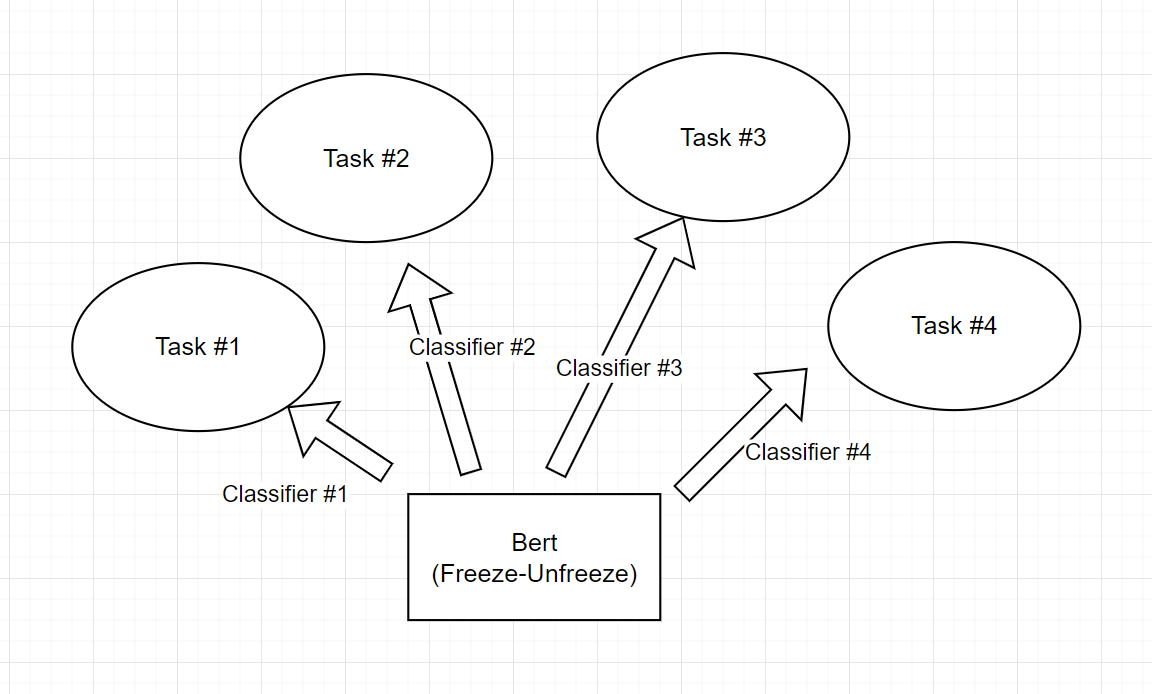


In our case we were not able to download and use different dataset, but we will explain the process for one dataset.

1. Initially be define an embedding model which is a embedding classifer, getting the embedding representain and predicting a class. These classifier should be different for each task.
2. We freeze the Base Model (some thing similar to Bert), that we start training the embedding classifier seperatly. Why this is good? Because the weights of the embedding network (similar to the softmax classifier in part 3) start with random weights, this randomness would cause some stochasticity in the base model weights, therefore, it will be best to freeze it.
3. After that the embedding classifier has been well fine-tuned, we will unfreeze the base model and start training it. In that case the base model is starting from a good point, and the main purpose of the model is not going to change significantly.

By using this approach for different datasets, we ensure that since the base model is frozen, being trained on different task is not going to impact it that much, and when the embedding classifer's are well fine-tuned then we could use our networks our models maximum capacity by using the base model.

# SupremeBert


In [ ]:
class SupremeBert(nn.Module):
    def __init__(self, pretrained_model: nn.Module, pool: str = None):
        super(SupremeBert, self).__init__()
        pretrained_model = pretrained_model.eval()
        self.base_bert = BaseBert(pretrained_model, pool)
        self.embedding_classifier = None
        self.model_type = 'classification'
        self.base_bert.requires_grad = True

    def forward(self, sentence1, sentence2):
        embedding = self.base_bert(sentence1, sentence2)
        return self.embedding_classifier(embedding)

    def set_head(self, embed_classifier):
        self.embedding_classifier = embed_classifier

    def get_head(self):
        return self.embedding_classifier

    def turn_on_base(self):
        self.base_bert.requires_grad = True

    def turn_off_base(self):
        self.base_bert.requires_grad = False


class BaseBert(nn.Module):
    def __init__(self, pretrained_model: nn.Module, pool: str = None):
        super(BaseBert, self).__init__()
        self.pretrained_model = pretrained_model
        assert pool == 'mean' or pool == 'max' or pool is None, "Pooling method not valid!"
        self.pool = pool

    def forward(self, sentence1, sentence2):
        sentence1_embed = self.pretrained_model(input_ids=sentence1[0], attention_mask=sentence1[1])
        sentence2_embed = self.pretrained_model(input_ids=sentence2[0], attention_mask=sentence2[1])
        if self.pool == 'max':
            sentence1_embed = torch.max(sentence1_embed[0], dim=2)[0]
            sentence2_embed = torch.max(sentence2_embed[0], dim=2)[0]
        elif self.pool == 'mean':
            sentence1_embed = sentence1_embed[0].mean(2)
            sentence2_embed = sentence2_embed[0].mean(2)
        elif self.pool is None:
            sentence1_embed = sentence1_embed[1]
            sentence2_embed = sentence2_embed[1]

        embedding = torch.cat([sentence1_embed, sentence2_embed, torch.abs(sentence1_embed - sentence2_embed),
                               sentence1_embed * sentence2_embed], dim=1)
        return embedding


class EmbedingClassifier(nn.Module):
    def __init__(self, input_channel: int, hidden_channel: int, output_channel: int):
        super(EmbedingClassifier, self).__init__()
        # self.layers = Softmax(input_channel, output_channel)
        self.layers = nn.Sequential(
            torch.nn.Linear(input_channel, hidden_channel),
            nn.ReLU(),
            nn.Linear(hidden_channel, hidden_channel),
            nn.ReLU(),
            torch.nn.Linear(hidden_channel, output_channel),
        )
        self.sf = nn.Softmax(dim=1)

    def forward(self, embedding):
        x = self.layers(embedding)
        # score = self.sf(x)
        return x

In [ ]:
    model_name = 'prajjwal1/bert-tiny'
    num_epochs = 3
    train_batch_size = 8
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512,
                   "vocab_size": 30522}

    # WARNING: Change this code if you implemented a different nli loader for this part
    nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

    # INFO: tokenize dataset
    # WARNING: Use only first 50000 samples and maximum sequence lenght of 128
    tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

    # INFO: generate train_dataloader
    train_dataloader = get_dataloader(tokenized_train, batch_size=train_batch_size)

    # INFO: generate train_dataloader
    sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

    # INFO: tokenize dataset
    tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)
    test_dataloader = get_dataloader(tokenized_test, batch_size=5)
    bert = Bert(bert_config).load_model('bert_tiny.bin')

    # supreme_bert = BertClassifier(bert, pool="mean", max_length=128, num_labels=3) #SupremeBert(bert, pool="mean")
    supreme_bert = SupremeBert(bert)
    embedding_NLI = EmbedingClassifier(input_channel=512, hidden_channel=100, output_channel=3)
    supreme_bert.set_head(embedding_NLI)
    # embedding_STS =

    # supreme_bert.set_head(embedding_NLI)

    # INFO: create optimizer and run training loop
    supreme_bert.turn_off_base()
    optimizer = AdamW(supreme_bert.parameters(), lr=5e-5)
    train_loop(supreme_bert, optimizer, train_dataloader, num_epochs, device)

    result_from_classification = eval_loop(supreme_bert, test_dataloader, device)
    print(
        f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

    supreme_bert.turn_on_base()
    optimizer = AdamW(supreme_bert.parameters(), lr=5e-5)
    train_loop(supreme_bert, optimizer, train_dataloader, num_epochs, device)

    result_from_classification = eval_loop(supreme_bert, test_dataloader, device)
    print(
        f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]


Pearson correlation: 0.44
Spearman correlation: 0.43


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]


Pearson correlation: 0.41
Spearman correlation: 0.40


In [ ]:
result_from_contrastive = eval_loop(bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

  0%|          | 0/276 [00:00<?, ?it/s]


Pearson correlation: 0.55
Spearman correlation: 0.57


## Last word

This model and approach showed promissing accuracy, if it has been trained on more dataset (which we were unable due to time limiations), we would defenitly have been able to achieve migher accuracy.

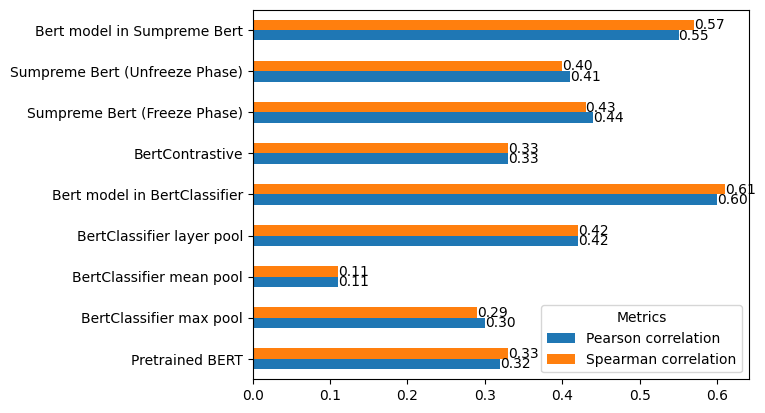

In [ ]:
import pandas as pd

test_df = pd.DataFrame({'Metrics': ['Pearson correlation', 'Spearman correlation'],
                        'Pretrained BERT': [0.32, 0.33],
                        'BertClassifier max pool': [0.30, 0.29],
                        'BertClassifier mean pool': [0.11, 0.11],
                        'BertClassifier layer pool': [0.42, 0.42],
                        'Bert model in BertClassifier': [0.60, 0.61],
                        'BertContrastive': [0.33, 0.33],
                        'Sumpreme Bert (Freeze Phase)': [0.44, 0.43],
                        'Sumpreme Bert (Unfreeze Phase)': [0.41, 0.40],
                        'Bert model in Sumpreme Bert': [0.55, 0.57]
                        })

# set name as the index and then Transpose the dataframe
test_df = test_df.set_index('Metrics').T


# plot and annotate
p1 = test_df.plot(kind="barh")

for p in p1.containers:
    p1.bar_label(p, fmt='%.2f', label_type='edge')